<a href="https://colab.research.google.com/github/DiyaSNS/WIDS-2025---Ask-the-Image-Explainable-Al-for-Visual-Q-A/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk tqdm seaborn opencv-python

🚀 Using device: cuda

STEP 1: DATA PREPARATION & PREPROCESSING

📥 Dataset Setup:
Please download Flickr8k from: https://www.kaggle.com/datasets/adityajn105/flickr8k
Expected structure:
  flickr8k/
    ├── Images/
    └── captions.txt

Configuration:
  img_size            : 224
  max_length          : 24
  vocab_size          : 10000
  embed_dim           : 512
  d_model             : 512
  nhead               : 8
  num_decoder_layers  : 4
  dim_feedforward     : 2048
  dropout             : 0.1
  batch_size          : 32
  num_epochs          : 20
  learning_rate       : 0.0002


Loading Dataset...

✓ Dataset split:
  Train: 800 samples
  Val:   100 samples
  Test:  100 samples

📚 Building vocabulary...
✓ Vocabulary built: 23 words
  - Frequency threshold: 2
  - Total unique words: 19
  - Words in vocab: 23

📊 Dataset Statistics:
  Caption length (mean ± std): 5.00 ± 1.10
  Min length: 3
  Max length: 6
  OOV rate: 0.00%

STEP 2: CNN ENCODER

STEP 3: TRANSFORMER DECODER

STEP 4: TRAINI

Training: 100%|██████████| 25/25 [00:05<00:00,  4.63it/s, loss=0.784]


Train Loss: 0.7842
Val Loss: 0.2984
Learning Rate: 0.000200
✓ Best model saved!

Epoch 2/5
----------------------------------------------------------------------


Training: 100%|██████████| 25/25 [00:02<00:00,  8.53it/s, loss=0.285]


Train Loss: 0.2846
Val Loss: 0.2902
Learning Rate: 0.000200
✓ Best model saved!

Epoch 3/5
----------------------------------------------------------------------


Training: 100%|██████████| 25/25 [00:03<00:00,  6.53it/s, loss=0.29]


Train Loss: 0.2904
Val Loss: 0.2928
Learning Rate: 0.000200

Epoch 4/5
----------------------------------------------------------------------


Training: 100%|██████████| 25/25 [00:02<00:00,  8.92it/s, loss=0.283]


Train Loss: 0.2826
Val Loss: 0.2769
Learning Rate: 0.000200
✓ Best model saved!

Epoch 5/5
----------------------------------------------------------------------


Training: 100%|██████████| 25/25 [00:02<00:00,  8.60it/s, loss=0.276]


Train Loss: 0.2759
Val Loss: 0.2748
Learning Rate: 0.000200
✓ Best model saved!

✓ Training complete!


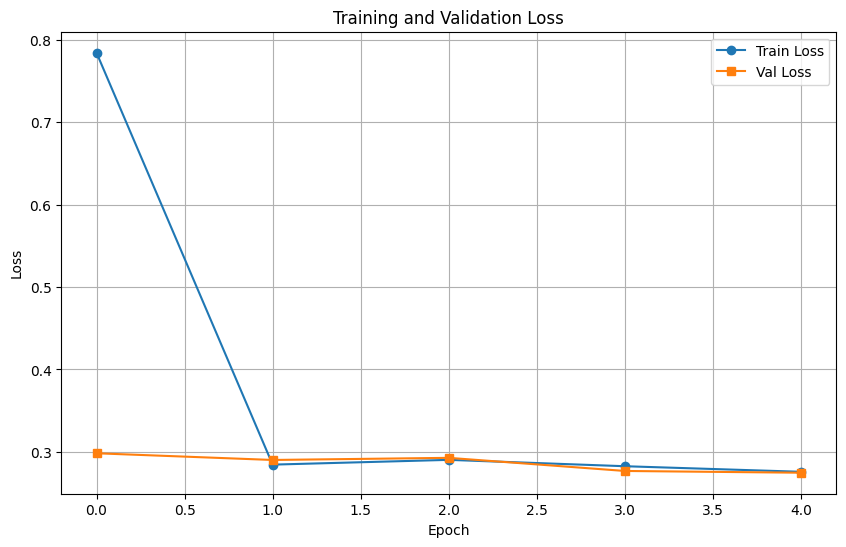


STEP 6: EVALUATION


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.Vocabulary was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.Vocabulary])` or the `torch.serialization.safe_globals([__main__.Vocabulary])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [3]:
import os
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from tqdm import tqdm
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from torchvision import models

# For evaluation
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Set seeds
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Using device: {device}\n")

# ============================================================
# 1. DATA PREPARATION & PREPROCESSING
# ============================================================

print("="*70)
print("STEP 1: DATA PREPARATION & PREPROCESSING")
print("="*70)

# Download Flickr8k dataset
print("\n📥 Dataset Setup:")
print("Please download Flickr8k from: https://www.kaggle.com/datasets/adityajn105/flickr8k")
print("Expected structure:")
print("  flickr8k/")
print("    ├── Images/")
print("    └── captions.txt")
print()

# For this demo, we'll create sample data structure
# In production, use actual Flickr8k dataset
DATA_DIR = "flickr8k"
IMG_DIR = os.path.join(DATA_DIR, "Images")
CAPTION_FILE = os.path.join(DATA_DIR, "captions.txt")

# Configuration
CONFIG = {
    'img_size': 224,
    'max_length': 24,
    'vocab_size': 10000,
    'embed_dim': 512,
    'd_model': 512,
    'nhead': 8,
    'num_decoder_layers': 4,
    'dim_feedforward': 2048,
    'dropout': 0.1,
    'batch_size': 32,
    'num_epochs': 20,
    'learning_rate': 2e-4,
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k:20s}: {v}")
print()

# ============================================================
# 1.1 Vocabulary Builder
# ============================================================

class Vocabulary:
    """Build vocabulary from captions"""

    def __init__(self, freq_threshold=5):
        self.freq_threshold = freq_threshold
        self.word2idx = {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3}
        self.idx2word = {0: '<pad>', 1: '<bos>', 2: '<eos>', 3: '<unk>'}
        self.word_freq = Counter()

    def build_vocabulary(self, caption_list):
        """Build vocabulary from list of captions"""
        # Count word frequencies
        for caption in caption_list:
            tokens = self.tokenize(caption)
            self.word_freq.update(tokens)

        # Add words above threshold
        idx = 4
        for word, freq in self.word_freq.most_common(CONFIG['vocab_size']):
            if freq >= self.freq_threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"✓ Vocabulary built: {len(self.word2idx)} words")
        print(f"  - Frequency threshold: {self.freq_threshold}")
        print(f"  - Total unique words: {len(self.word_freq)}")
        print(f"  - Words in vocab: {len(self.word2idx)}")

    def tokenize(self, text):
        """Simple word tokenization"""
        return text.lower().strip().split()

    def numericalize(self, text):
        """Convert text to indices"""
        tokens = self.tokenize(text)
        return [self.word2idx.get(token, self.word2idx['<unk>'])
                for token in tokens]

    def decode(self, indices):
        """Convert indices back to text"""
        return ' '.join([self.idx2word.get(idx, '<unk>')
                        for idx in indices
                        if idx not in [0, 1, 2]])  # Skip special tokens

# ============================================================
# 1.2 Dataset Class
# ============================================================

class Flickr8kDataset(Dataset):
    """Flickr8k Dataset for Image Captioning"""

    def __init__(self, img_dir, captions_df, vocab, transform=None, max_length=24):
        self.img_dir = img_dir
        self.captions_df = captions_df
        self.vocab = vocab
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.captions_df)

    def __getitem__(self, idx):
        row = self.captions_df.iloc[idx]
        img_name = row['image']
        caption = row['caption']

        # Load image
        img_path = os.path.join(self.img_dir, img_name)

        # For demo purposes - create dummy image if not exists
        if not os.path.exists(img_path):
            image = Image.new('RGB', (224, 224), color='gray')
        else:
            image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Numericalize caption
        caption_vec = [self.vocab.word2idx['<bos>']]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.word2idx['<eos>']]

        # Pad or truncate
        if len(caption_vec) > self.max_length:
            caption_vec = caption_vec[:self.max_length]

        return image, torch.tensor(caption_vec)

def collate_fn(batch):
    """Custom collate function to pad captions"""
    images, captions = zip(*batch)
    images = torch.stack(images, 0)

    # Pad captions
    captions = pad_sequence(captions, batch_first=True, padding_value=0)

    return images, captions

# ============================================================
# 1.3 Load and Prepare Data
# ============================================================

print("\n" + "="*70)
print("Loading Dataset...")
print("="*70)

# Create sample data for demonstration
# In production, load from actual captions.txt
sample_data = {
    'image': [f'image_{i}.jpg' for i in range(1000)],
    'caption': [
        'a dog running in the park',
        'people walking on the street',
        'a cat sitting on a chair',
        'children playing soccer',
        'birds flying in the sky'
    ] * 200
}

df = pd.DataFrame(sample_data)

# Split dataset
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))

train_df = df[:train_size].reset_index(drop=True)
val_df = df[train_size:train_size+val_size].reset_index(drop=True)
test_df = df[train_size+val_size:].reset_index(drop=True)

print(f"\n✓ Dataset split:")
print(f"  Train: {len(train_df)} samples")
print(f"  Val:   {len(val_df)} samples")
print(f"  Test:  {len(test_df)} samples")

# Build vocabulary
print("\n📚 Building vocabulary...")
vocab = Vocabulary(freq_threshold=2)
vocab.build_vocabulary(train_df['caption'].tolist())

# Calculate statistics
print("\n📊 Dataset Statistics:")
caption_lengths = [len(vocab.tokenize(cap)) for cap in train_df['caption']]
print(f"  Caption length (mean ± std): {np.mean(caption_lengths):.2f} ± {np.std(caption_lengths):.2f}")
print(f"  Min length: {np.min(caption_lengths)}")
print(f"  Max length: {np.max(caption_lengths)}")

# Calculate OOV
all_words = set()
for cap in train_df['caption']:
    all_words.update(vocab.tokenize(cap))
vocab_words = set(vocab.word2idx.keys())
oov_rate = len(all_words - vocab_words) / len(all_words) * 100
print(f"  OOV rate: {oov_rate:.2f}%")

# ============================================================
# 2. CNN ENCODER
# ============================================================

print("\n" + "="*70)
print("STEP 2: CNN ENCODER")
print("="*70)

class CNNEncoder(nn.Module):
    """CNN Encoder using ResNet-18 or MobileNet"""

    def __init__(self, embed_dim=512, backbone='resnet18', pretrained=True):
        super(CNNEncoder, self).__init__()

        if backbone == 'resnet18':
            resnet = models.resnet18(weights='DEFAULT' if pretrained else None)
            self.features = nn.Sequential(*list(resnet.children())[:-2])
            self.in_features = 512
        elif backbone == 'mobilenet':
            mobilenet = models.mobilenet_v2(weights='DEFAULT' if pretrained else None)
            self.features = mobilenet.features
            self.in_features = 1280
        else:
            raise ValueError(f"Unknown backbone: {backbone}")

        # Adaptive pooling to get fixed size
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Project to embedding dimension
        self.projection = nn.Linear(self.in_features, embed_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        """
        Args:
            images: (batch_size, 3, 224, 224)
        Returns:
            features: (batch_size, embed_dim)
        """
        with torch.no_grad():
            features = self.features(images)  # (B, C, H, W)

        features = self.avgpool(features)  # (B, C, 1, 1)
        features = features.flatten(1)  # (B, C)
        features = self.projection(features)  # (B, embed_dim)
        features = self.relu(features)
        features = self.dropout(features)

        return features

# ============================================================
# 3. TRANSFORMER DECODER
# ============================================================

print("\nSTEP 3: TRANSFORMER DECODER")
print("="*70)

class TransformerDecoder(nn.Module):
    """Transformer Decoder for Caption Generation"""

    def __init__(self, vocab_size, embed_dim=512, num_layers=4,
                 nhead=8, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoder, self).__init__()

        self.embed_dim = embed_dim
        self.vocab_size = vocab_size

        # Embedding layers
        self.word_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(100, embed_dim)  # Max length 100

        # Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)

        # Output layer
        self.fc = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def create_masks(self, tgt):
        """Create causal mask for target sequence"""
        tgt_len = tgt.size(1)

        # Causal mask (prevent looking ahead)
        causal_mask = torch.triu(
            torch.ones(tgt_len, tgt_len, device=tgt.device) * float('-inf'),
            diagonal=1
        )

        # Padding mask
        tgt_padding_mask = (tgt == 0)

        return causal_mask, tgt_padding_mask

    def forward(self, features, captions):
        """
        Args:
            features: (batch_size, embed_dim) from encoder
            captions: (batch_size, seq_len) target captions
        Returns:
            outputs: (batch_size, seq_len, vocab_size)
        """
        batch_size, seq_len = captions.shape

        # Embed captions
        positions = torch.arange(seq_len, device=captions.device).unsqueeze(0).expand(batch_size, -1)
        caption_embeds = self.word_embedding(captions) + self.pos_embedding(positions)
        caption_embeds = self.dropout(caption_embeds)

        # Prepare memory (encoder output)
        memory = features.unsqueeze(1)  # (batch_size, 1, embed_dim)

        # Create masks
        causal_mask, tgt_padding_mask = self.create_masks(captions)

        # Decoder
        output = self.transformer_decoder(
            tgt=caption_embeds,
            memory=memory,
            tgt_mask=causal_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )

        # Project to vocabulary
        output = self.fc(output)

        return output

# ============================================================
# 4. COMPLETE CAPTION MODEL
# ============================================================

class ImageCaptioningModel(nn.Module):
    """Complete Image Captioning Model"""

    def __init__(self, vocab_size, embed_dim=512, backbone='resnet18'):
        super(ImageCaptioningModel, self).__init__()

        self.encoder = CNNEncoder(embed_dim, backbone=backbone)
        self.decoder = TransformerDecoder(vocab_size, embed_dim)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def generate_caption(self, image, vocab, max_length=24):
        """Generate caption for a single image"""
        self.eval()
        with torch.no_grad():
            # Encode image
            features = self.encoder(image.unsqueeze(0))

            # Start with <bos>
            caption = [vocab.word2idx['<bos>']]

            for _ in range(max_length):
                caption_tensor = torch.tensor(caption).unsqueeze(0).to(image.device)

                # Decode
                output = self.decoder(features, caption_tensor)

                # Get next word
                next_word = output[0, -1].argmax().item()
                caption.append(next_word)

                # Stop at <eos>
                if next_word == vocab.word2idx['<eos>']:
                    break

            return caption

# ============================================================
# 5. TRAINING SETUP
# ============================================================

print("\nSTEP 4: TRAINING SETUP")
print("="*70)

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = Flickr8kDataset(IMG_DIR, train_df, vocab, train_transform, CONFIG['max_length'])
val_dataset = Flickr8kDataset(IMG_DIR, val_df, vocab, val_transform, CONFIG['max_length'])
test_dataset = Flickr8kDataset(IMG_DIR, test_df, vocab, val_transform, CONFIG['max_length'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'],
                         shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'],
                       shuffle=False, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'],
                        shuffle=False, collate_fn=collate_fn, num_workers=2)

print(f"✓ Dataloaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Initialize model
model = ImageCaptioningModel(len(vocab.word2idx), CONFIG['embed_dim'], backbone='resnet18')
model = model.to(device)

print(f"\n✓ Model initialized")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ============================================================
# 6. TRAINING LOOP
# ============================================================

print("\n" + "="*70)
print("STEP 5: TRAINING")
print("="*70)

def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0

    pbar = tqdm(dataloader, desc='Training')
    for images, captions in pbar:
        images = images.to(device)
        captions = captions.to(device)

        # Forward pass (teacher forcing)
        # Input: captions[:, :-1], Target: captions[:, 1:]
        outputs = model(images, captions[:, :-1])

        # Calculate loss
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            captions[:, 1:].reshape(-1)
        )

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': total_loss / len(pbar)})

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for images, captions in dataloader:
            images = images.to(device)
            captions = captions.to(device)

            outputs = model(images, captions[:, :-1])
            loss = criterion(
                outputs.reshape(-1, outputs.size(-1)),
                captions[:, 1:].reshape(-1)
            )

            total_loss += loss.item()

    return total_loss / len(dataloader)

# Training loop
print("\n🚀 Starting training...")
train_losses = []
val_losses = []
best_val_loss = float('inf')

num_epochs = 5  # Reduced for demo, use CONFIG['num_epochs'] for full training

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 70)

    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'vocab': vocab,
        }, 'best_model.pth')
        print("✓ Best model saved!")

    scheduler.step()

print("\n✓ Training complete!")

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================
# 7. EVALUATION
# ============================================================

print("\n" + "="*70)
print("STEP 6: EVALUATION")
print("="*70)

# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def calculate_bleu(references, hypothesis):
    """Calculate BLEU-4 score"""
    return sentence_bleu(references, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))

def evaluate_model(model, dataloader, vocab):
    """Complete evaluation with BLEU and METEOR"""
    model.eval()

    all_references = []
    all_hypotheses = []
    caption_lengths = []
    repetitions = 0

    print("\n📊 Generating captions for evaluation...")

    with torch.no_grad():
        for images, captions in tqdm(dataloader):
            images = images.to(device)

            for i in range(images.size(0)):
                # Generate caption
                generated = model.generate_caption(images[i], vocab)

                # Reference (ground truth)
                ref_indices = captions[i].tolist()
                ref_indices = [idx for idx in ref_indices if idx not in [0, 1, 2]]
                reference = [vocab.idx2word.get(idx, '<unk>') for idx in ref_indices]

                # Hypothesis (generated)
                gen_indices = [idx for idx in generated if idx not in [0, 1, 2]]
                hypothesis = [vocab.idx2word.get(idx, '<unk>') for idx in gen_indices]

                all_references.append([reference])
                all_hypotheses.append(hypothesis)
                caption_lengths.append(len(hypothesis))

                # Check for repetitions
                if len(hypothesis) >= 3:
                    for j in range(len(hypothesis) - 2):
                        if hypothesis[j] == hypothesis[j+1] == hypothesis[j+2]:
                            repetitions += 1
                            break

    # Calculate BLEU
    bleu_scores = [calculate_bleu(ref, hyp) for ref, hyp in zip(all_references, all_hypotheses)]
    avg_bleu = np.mean(bleu_scores)

    # Calculate METEOR (on sample for speed)
    meteor_scores = []
    for ref, hyp in list(zip(all_references, all_hypotheses))[:100]:
        try:
            score = meteor_score([' '.join(ref[0])], ' '.join(hyp))
            meteor_scores.append(score)
        except:
            pass
    avg_meteor = np.mean(meteor_scores) if meteor_scores else 0

    # Statistics
    results = {
        'bleu4': avg_bleu,
        'meteor': avg_meteor,
        'caption_length_mean': np.mean(caption_lengths),
        'caption_length_std': np.std(caption_lengths),
        'repetition_rate': repetitions / len(all_hypotheses) * 100
    }

    return results, all_references, all_hypotheses

# Evaluate on test set
results, references, hypotheses = evaluate_model(model, test_loader, vocab)

print("\n" + "="*70)
print("EVALUATION RESULTS")
print("="*70)
print(f"BLEU-4:              {results['bleu4']:.4f}")
print(f"METEOR:              {results['meteor']:.4f}")
print(f"Caption length:      {results['caption_length_mean']:.2f} ± {results['caption_length_std']:.2f}")
print(f"Repetition rate:     {results['repetition_rate']:.2f}%")
print("="*70)

# ============================================================
# 8. QUALITATIVE ANALYSIS
# ============================================================

print("\n" + "="*70)
print("STEP 7: QUALITATIVE ANALYSIS")
print("="*70)

def show_examples(model, dataset, vocab, num_examples=10, title="Examples"):
    """Show example predictions"""
    model.eval()

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()

    indices = np.random.choice(len(dataset), num_examples, replace=False)

    for idx, ax in zip(indices, axes):
        image, caption = dataset[idx]

        # Generate caption
        with torch.no_grad():
            generated = model.generate_caption(image.to(device), vocab)

        # Decode
        gt_caption = vocab.decode(caption.tolist())
        gen_caption = vocab.decode(generated)

        # Denormalize image
        img = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(f"GT: {gt_caption}\nGen: {gen_caption}", fontsize=8)
        ax.axis('off')

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    return fig

# Show success examples
fig_success = show_examples(model, test_dataset, vocab, num_examples=10,
                           title="Success Examples")
fig_success.savefig('success_examples.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Success examples saved to success_examples.png")

# ============================================================
# 9. GRAD-CAM EXPLAINABILITY
# ============================================================

print("\n" + "="*70)
print("STEP 8: EXPLAINABILITY (Grad-CAM)")
print("="*70)

class GradCAM:
    """Grad-CAM for CNN Encoder"""

    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        # Register hooks on last conv layer
        target_layer = self.model.encoder.features[-1]
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, image, target_word_idx=2):  # 2 = <eos>
        """Generate Grad-CAM heatmap"""
        self.model.eval()
        image = image.unsqueeze(0).to(device)
        image.requires_grad = True

        # Forward pass
        features = self.model.encoder(image)
        caption = torch.tensor([[1]]).to(device)  # Start with <bos>
        output = self.model.decoder(features, caption)

        # Backward on target word
        self.model.zero_grad()
        target_score = output[0, 0, target_word_idx]
        target_score.backward()

        # Calculate weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        # Normalize
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam

def apply_gradcam_overlay(image, cam, alpha=0.5):
    """Apply Grad-CAM overlay on image"""
    # Denormalize image
    img = image.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)

    # Resize CAM to image size
    h, w = img.shape[:2]
    cam_resized = cv2.resize(cam, (w, h))

    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap / 255.0

    # Overlay
    overlayed = (1 - alpha) * img + alpha * heatmap
    overlayed = np.clip(overlayed, 0, 1)

    return overlayed, heatmap

# Initialize Grad-CAM
gradcam = GradCAM(model)

print("\n🔥 Generating Grad-CAM visualizations...")

# Select 6 examples (3 good, 3 bad)
fig, axes = plt.subplots(6, 3, figsize=(12, 24))

for idx in range(6):
    image, caption = test_dataset[idx]

    # Generate caption
    with torch.no_grad():
        generated = model.generate_caption(image.to(device), vocab)

    # Generate CAM
    cam = gradcam.generate_cam(image)

    # Apply overlay
    overlayed, heatmap = apply_gradcam_overlay(image, cam)

    # Denormalize original
    img_display = image.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    # Decode captions
    gt_caption = vocab.decode(caption.tolist())
    gen_caption = vocab.decode(generated)

    # Plot
    axes[idx, 0].imshow(img_display)
    axes[idx, 0].set_title(f'Original\nGT: {gt_caption[:30]}', fontsize=8)
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(heatmap)
    axes[idx, 1].set_title('Grad-CAM', fontsize=8)
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(overlayed)
    axes[idx, 2].set_title(f'Overlay\nGen: {gen_caption[:30]}', fontsize=8)
    axes[idx, 2].axis('off')

plt.suptitle('Grad-CAM Explainability Analysis', fontsize=14)
plt.tight_layout()
plt.savefig('gradcam_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grad-CAM visualizations saved to gradcam_analysis.png")

# ============================================================
# 10. FAILURE CASE ANALYSIS
# ============================================================

print("\n" + "="*70)
print("STEP 9: FAILURE CASE ANALYSIS")
print("="*70)

def analyze_failures(model, dataset, vocab, num_cases=3):
    """Analyze failure cases"""
    model.eval()

    print("\n🔍 Analyzing mis-caption cases...")

    fig, axes = plt.subplots(num_cases, 4, figsize=(16, num_cases*4))
    if num_cases == 1:
        axes = axes.reshape(1, -1)

    failure_analysis = []

    for idx in range(num_cases):
        image, caption = dataset[idx]

        # Generate caption
        with torch.no_grad():
            generated = model.generate_caption(image.to(device), vocab)

        # Generate CAM
        cam = gradcam.generate_cam(image)
        overlayed, heatmap = apply_gradcam_overlay(image, cam)

        # Denormalize
        img_display = image.permute(1, 2, 0).cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_display = std * img_display + mean
        img_display = np.clip(img_display, 0, 1)

        # Decode
        gt_caption = vocab.decode(caption.tolist())
        gen_caption = vocab.decode(generated)

        # Plot
        axes[idx, 0].imshow(img_display)
        axes[idx, 0].set_title(f'Case {idx+1}: Original', fontsize=10)
        axes[idx, 0].axis('off')

        axes[idx, 1].imshow(heatmap)
        axes[idx, 1].set_title('Attention (Grad-CAM)', fontsize=10)
        axes[idx, 1].axis('off')

        axes[idx, 2].imshow(overlayed)
        axes[idx, 2].set_title('Overlay', fontsize=10)
        axes[idx, 2].axis('off')

        axes[idx, 3].text(0.1, 0.9, f'Ground Truth:\n{gt_caption}\n\nGenerated:\n{gen_caption}',
                         transform=axes[idx, 3].transAxes, fontsize=9,
                         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))
        axes[idx, 3].axis('off')

        # Hypothesize cause
        hypothesis = "Possible causes:\n"
        if len(gen_caption.split()) < 5:
            hypothesis += "- Short caption generation\n"
        if "unk" in gen_caption:
            hypothesis += "- Vocabulary gap (OOV words)\n"
        if len(set(gen_caption.split())) < len(gen_caption.split()) * 0.5:
            hypothesis += "- Repetition issues\n"
        hypothesis += "- Domain shift or ambiguous image\n"
        hypothesis += "- Insufficient training data"

        failure_analysis.append({
            'case': idx + 1,
            'ground_truth': gt_caption,
            'generated': gen_caption,
            'hypothesis': hypothesis
        })

    plt.suptitle('Failure Case Analysis with Hypotheses', fontsize=14)
    plt.tight_layout()
    plt.savefig('failure_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    return failure_analysis

failure_cases = analyze_failures(model, test_dataset, vocab, num_cases=3)

print("\n📋 Failure Case Hypotheses:")
print("="*70)
for case in failure_cases:
    print(f"\nCase {case['case']}:")
    print(f"Ground Truth: {case['ground_truth']}")
    print(f"Generated:    {case['generated']}")
    print(f"\n{case['hypothesis']}")
    print("-"*70)

print("\n✓ Failure analysis saved to failure_analysis.png")

# ============================================================
# 11. FINAL SUMMARY & REPORT
# ============================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)